In [1]:
import comet_ml
from comet_ml.query import Parameter

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from IPython.core.display import display, HTML

In [2]:
def get_epoch_info(df):
    df_train = df[~ df['train_1mae_epoch'].isnull()][['epoch', 'train_1mae_epoch']]
    df_valid = df[~ df['valid_1mae'].isnull()][['epoch', 'valid_1mae']]
    return df_train.merge(df_valid, on='epoch')

In [3]:
comet_api = comet_ml.api.API()

In [4]:
exps = comet_api.query("transformer", "compare-loss", Parameter('limit') == 1.0)
still_running = []#['3b9590b112734f4199faee4e671656d4', 'b1463f45e22c47eb97f2b9e47c73c640', '69b1e264cb9e4fa0a0e91cb7e541ab00']

In [5]:
csv_dir = Path('logs/csv')

In [6]:
dfs = {}
for exp in exps:
    i = exp.id
    dfs[i] = pd.read_csv(csv_dir / i / "version_0" / "metrics.csv")

In [7]:
dfs = {k: get_epoch_info(df) for k, df in dfs.items()}

In [8]:
dfs_list = list(dfs.values())

In [12]:
wrong_ids = []
for k, df in dfs.items():
    if k in still_running:
        continue
    ac_max = list(np.maximum.accumulate(df['valid_1mae']))
    if (ac_max[-11] != ac_max[-1]): # or ((len(ac_max) > 11) and (ac_max[-12] == ac_max[-11])):
        wrong_ids.append(k)

In [13]:
n_wrong = len(wrong_ids)
n_total = len(dfs_list) - len(still_running)
print(f"{n_wrong} out of {n_total} are not fulfilling the early stopping criteria!")

3 out of 18 are not fulfilling the early stopping criteria!


In [14]:
urls = [f"https://www.comet.ml/transformer/compare-loss/{i}?experiment-tab=params" for i in wrong_ids]
for url in urls:
    display(HTML(f'<a href="{url}">{url}</a>'))

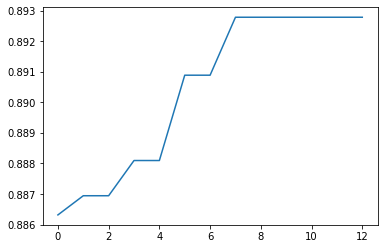

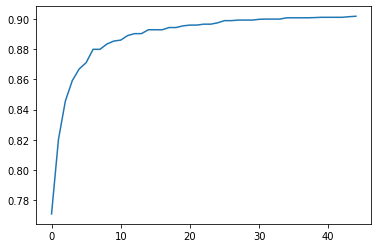

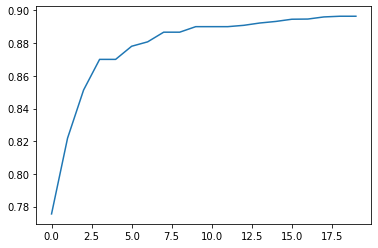

In [15]:
for k in wrong_ids:
    df = dfs[k]
    plt.plot(np.maximum.accumulate(df['valid_1mae']))
    plt.show()

In [16]:
longest_i = np.argmax([len(df) for df in dfs_list])
dfs_list[longest_i]

,epoch,train_1mae_epoch,valid_1mae
0,0,0.632925,0.762362
1,1,0.713806,0.816591
2,2,0.756329,0.852981
3,3,0.784413,0.862825
4,4,0.807671,0.873937
...,...,...,...
142,142,0.916652,0.898382
143,143,0.916544,0.896839
144,144,0.916609,0.898036
145,145,0.917152,0.896635


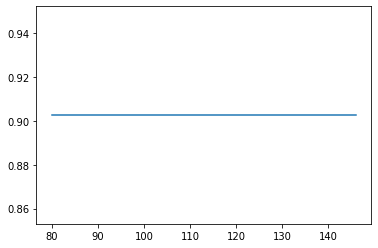

In [17]:
df = dfs_list[longest_i]
plt.plot(np.maximum.accumulate(df['valid_1mae'])[80:])
plt.show()

In [18]:
list(np.maximum.accumulate(df['valid_1mae']))

[0.7623615860939026,
 0.8165909051895142,
 0.8529809713363647,
 0.8628250360488892,
 0.8739368915557861,
 0.8776467442512512,
 0.8838008642196655,
 0.8844567537307739,
 0.8863764405250549,
 0.8869461417198181,
 0.8882648944854736,
 0.8901271820068359,
 0.8919320702552795,
 0.8925473690032959,
 0.8925473690032959,
 0.8935675024986267,
 0.894243597984314,
 0.8950281143188477,
 0.8952749967575073,
 0.8952749967575073,
 0.8961787223815918,
 0.8977454304695129,
 0.8977454304695129,
 0.8977454304695129,
 0.8978537321090698,
 0.8982553482055664,
 0.8982874751091003,
 0.8982874751091003,
 0.8990259766578674,
 0.8993280529975891,
 0.8993468284606934,
 0.8993468284606934,
 0.899398684501648,
 0.8998994827270508,
 0.9000629186630249,
 0.9000629186630249,
 0.9001181721687317,
 0.9001754522323608,
 0.9001754522323608,
 0.9002217054367065,
 0.9007129669189453,
 0.9007129669189453,
 0.9012436270713806,
 0.9012436270713806,
 0.901250958442688,
 0.901250958442688,
 0.901250958442688,
 0.901643633842468